In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

import matplotlib.pyplot as plt

from xgboost import XGBClassifier


# Necessary to get names out
SimpleImputer.get_feature_names_out = (lambda self, names=None:
                                       self.feature_names_in_)

d:\python\python38\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [59]:
features_num = [
    "Z_BEST", "z1_median", "u_f", "u_e", "u_e_raw", "Bw_f", "Bw_e", "Bw_e_raw", "R_f", "R_e", 
    "R_e_raw", "I_f", "I_e", "I_e_raw", "z_f", "z_e", "z_e_raw", "z_Subaru_f", "z_Subaru_e", 
    "z_Subaru_e_raw", "y_f", "y_e", "y_e_raw", "J_f", "J_e", "J_e_raw", "H_f", 
    "H_e", "H_e_raw", "K_f", "K_e", "K_e_raw", "Ks_f", "Ks_e", "Ks_e_raw", "ch1_f", "ch1_e", "ch1_e_raw", "ch2_f", 
    "ch2_e", "ch2_e_raw", "ch3_f", "ch3_e", "ch3_e_raw", "ch4_f", "ch4_e", "ch4_e_raw", "MIPS_24_f", 
    "MIPS_24_e", "MIPS_24_e_raw", "PACS_100_f", "PACS_100_e", "PACS_100_e_raw", "PACS_160_f", "PACS_160_e", 
    "PACS_160_e_raw", "SPIRE_250_f", "SPIRE_250_e", "SPIRE_250_e_raw", "SPIRE_350_f", "SPIRE_350_e", "SPIRE_350_e_raw", 
    "SPIRE_500_f", "SPIRE_500_e", "SPIRE_500_e_raw"

]
features_cat = [
    "FLAG_DEEP", "FLAG_OVERLAP", "XID+_rerun_mips", "XID+_rerun_pacs", "XID+_rerun_SPIRE", "CHANGE_FLAG_ID", 
    "CHANGE_FLAG_ZBEST", "CHANGE_FLAG_DEEP", "CHANGE_FLAG_FIR", "FLAG_GOOD"
]
features_drop = [
    "Source_Name"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [69]:
imp_mean_num = SimpleImputer()
imp_median_cat = SimpleImputer(strategy="most_frequent")

In [70]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/Bootes_clean.csv")

In [71]:
# Dropping required columns
X = data.drop(columns=features_drop)
X = X.drop(columns=y_column)
y = data[y_column]

# Transforming y to labels
le = preprocessing.LabelEncoder()
labels = np.unique(y)
y = le.fit_transform(y)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [72]:
# filling missing values for each class respectively
for classification in classes:
    condition = data['Classification'] == classification
    
    # Making sure we dont accidently train even the imputer to the test set
    X_train.loc[condition, features_num] = imp_mean_num.fit_transform(X_train.loc[condition, features_num])
    X_train.loc[condition, features_cat] = imp_median_cat.fit_transform(X_train.loc[condition, features_cat])
    
    # Note the difference, not fitting, just transforming
    X_test.loc[condition, features_num] = imp_mean_num.transform(X_test.loc[condition, features_num])
    X_test.loc[condition, features_cat] = imp_median_cat.transform(X_test.loc[condition, features_cat])

In [82]:
clf = RandomForestClassifier(n_estimators=50, class_weight=None)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [83]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9373    0.8233    0.8766       962
quasar-like radio AGN / high-excitation radio galaxy     0.9394    0.2562    0.4026       121
                                     radio-quiet AGN     0.8447    0.7542    0.7969       541
                                 star-forming galaxy     0.9179    0.9832    0.9494      3695

                                            accuracy                         0.9145      5319
                                           macro avg     0.9098    0.7042    0.7564      5319
                                        weighted avg     0.9144    0.9145    0.9083      5319



[]

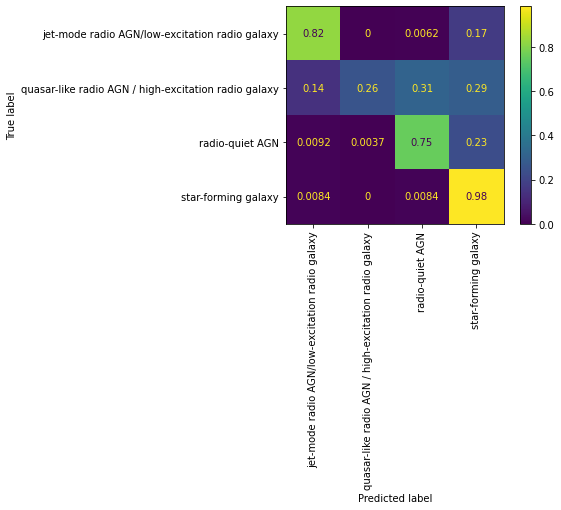

In [84]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

In [85]:
random_forest_feature_importance = pd.DataFrame(
    np.array([preprocessor.get_feature_names_out(), clf.feature_importances_]).T,
                                               columns=['Feature', 'Importance'])
random_forest_feature_importance = random_forest_feature_importance.sort_values(by=['Importance'], ascending=False)

NameError: name 'preprocessor' is not defined